<a href="https://colab.research.google.com/github/hurricane195/Intro-to-Deep-Learning/blob/Homework_2/HW2_P2A__Without_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 2

The baseline model we did in lectures is called ResNet-11. **Build a new version of ResNet (ResNet-18). Train it on CIFAR-10. Plot the training loss, validation loss, and validation accuracy. Compare the classification accuracy, and model size across the two versions of ResNet (11, 18). How does the complexity grow as you increase the network depth?**

You can find some references for ResNet 18 here:

https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorchLinks to an external site.

Explore the dropout option for the two networks and report your training results and validation accuracy.

In [ ]:
#Building off Homework 6 Problem 2B submitted for Intro to ML
#Using modified CIFAR-10 example from 'Deep-Learning-with_PyTorch' in Chapter 8 'Using Convolutions to generalize'.
#Using modified CIFAR-10 example from 'Deep-Learning-with_PyTorch' in Chapter 7 'Telling Birds from airplanes: Learning from images'.
#Using modified Temperature example from 'Deep-Learning-with_PyTorch' in Chapter 6 'Using a neural network to fit the data'.
#Using a modided example of Dr. Tabkhi's "ResNet11" available at https://github.com/HamedTabkhi/Intro-to-DL/blob/main/ResNet11.py
#Using a modified portion from "ResNet18 from scratch using Pytorch" at https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch
#Help from ChatGPT
#Help from Google Colab AI assist with Colab Pro

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import time
import datetime

import torch.nn.functional as F  # Functional module for activation functions and more

In [ ]:
data_path = '../data-unversioned/p1ch7/'
CIFAR10 = datasets.CIFAR10(data_path, train = True, download = True)
#test_dataset = datasets.CIFAR10(data_path, train = False, download = True)

100%|██████████| 170498071/170498071 [00:06<00:00, 28059417.43it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/


In [ ]:
classes = CIFAR10.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

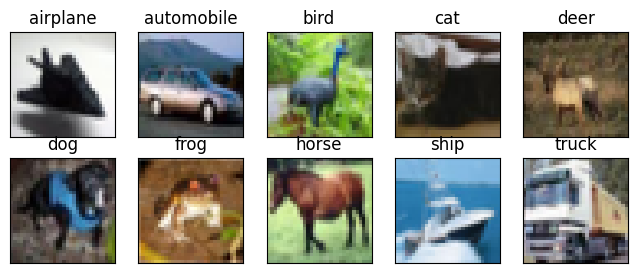

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    #ax.set_title(le.fit(class_names))
    img = next(img for img, label in CIFAR10 if label ==i)
    plt.imshow(img)
plt.show()

In [ ]:
tensor_train_dataset = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_train_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
train_dataset = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
test_dataset = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [ ]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


RESNET18

Four residual blocks in total, one per layer

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # Forward pass through the first convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through the second convolution and batch norm
        out = self.bn2(self.conv2(out))
        # Adding the shortcut connection's output to the main path's output
        out += self.shortcut(x)
        # Final ReLU activation after adding the shortcut
        out = F.relu(out)
        return out



In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Final fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear(out)  # Final classification layer
        return out

#ResNet18: has 18 layers in total, including convolutional and fully connected layers.
#It comprises 4 residual blocks, each containing a varying number of convolutional layers, resulting in a total of 18 layers.

In [ ]:
# Example of using the ResNet18 model
model = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)  # 4 blocks with 2 layer each

In [ ]:
# Move model to Device
model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11173962

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch [1/20], Training Loss: 1.3805, Training Accuracy: 49.56%, Validation Accuracy: 53.92%
Epoch [2/20], Training Loss: 0.9104, Training Accuracy: 67.70%, Validation Accuracy: 54.19%
Epoch [3/20], Training Loss: 0.6623, Training Accuracy: 76.83%, Validation Accuracy: 64.91%
Epoch [4/20], Training Loss: 0.4754, Training Accuracy: 83.47%, Validation Accuracy: 61.17%
Epoch [5/20], Training Loss: 0.3152, Training Accuracy: 89.27%, Validation Accuracy: 72.41%
Epoch [6/20], Training Loss: 0.1838, Training Accuracy: 94.11%, Validation Accuracy: 73.47%
Epoch [7/20], Training Loss: 0.1084, Training Accuracy: 96.49%, Validation Accuracy: 66.38%
Epoch [8/20], Training Loss: 0.0595, Training Accuracy: 98.30%, Validation Accuracy: 75.95%
Epoch [9/20], Training Loss: 0.0313, Training Accuracy: 99.26%, Validation Accuracy: 78.66%
Epoch [10/20], Training Loss: 0.0151, Training Accuracy: 99.69%, Validation Accuracy: 77.09%
Epoch [11/20], Training Loss: 0.0073, Training Accuracy: 99.91%, Validation Acc

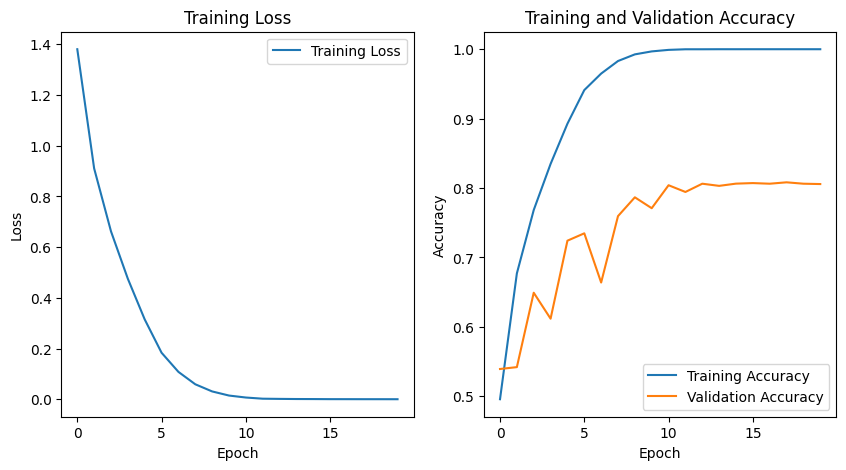

In [ ]:
start_training = time.time()

# Training the model
train_losses = []
train_accuracy = []
val_accuracy = []

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
         # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

  # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
    main_toc = time.perf_counter()

    val_accuracy.append(correct_val / total_val)


    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_losses[-1]:.4f}, '
          f'Training Accuracy: {train_accuracy[-1]*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy[-1]*100:.2f}%')

# Display training time
print('')
print('Training time:   {:.2f}s'.format(time.time() - start_training))
print('')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save trained model
#torch.save(model.state_dict(), 'CIFAR10_model.pth')

Precision: 0.8060323667120939
Recall: 0.8057
F1 Score: 0.8054837752937115
Accuracy: 0.8057

Confusion Matrix:
[[848  13  33  12   9   7   5   8  42  23]
 [  7 898   2  10   1   4   5   4  11  58]
 [ 64   4 698  56  59  45  43  18   6   7]
 [ 18   7  45 633  40 174  43  17   6  17]
 [ 21   5  51  42 772  33  31  33   9   3]
 [ 15   2  20 122  39 746  14  33   5   4]
 [ 11   6  31  47  17  19 857   6   2   4]
 [ 14   2  17  37  45  42   4 829   3   7]
 [ 38  17   9  10   2   6   1   2 901  14]
 [ 21  51   5  13   1   3   7   7  17 875]]



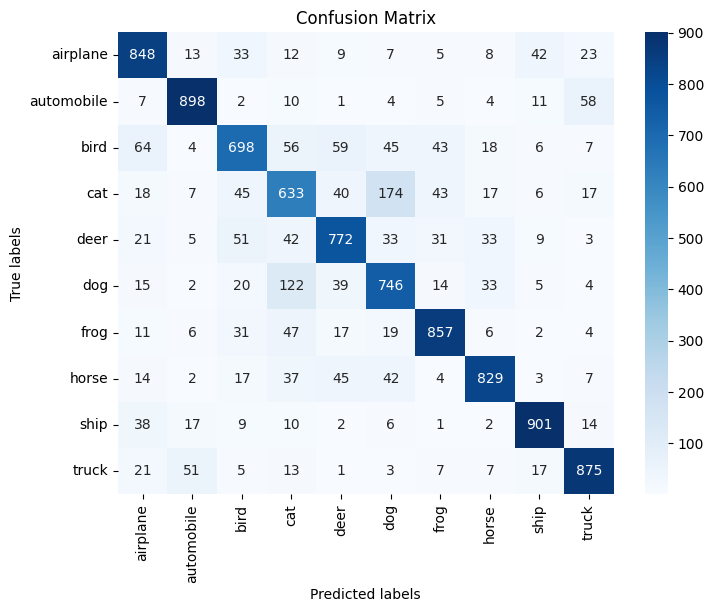

In [ ]:
import seaborn as sns

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Calculate metrics
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("")
print("Confusion Matrix:")
print(conf_matrix)
print("")

# Plotting the confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()